In [2]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data preprocessing
# Define Paths
import random

CURR_PATH = os.getcwd()
data_path = os.path.join(CURR_PATH, 'data', 'phase2', 'total')
train_path = os.path.join(CURR_PATH, 'data', 'phase2', 'train')
test_path = os.path.join(CURR_PATH, 'data', 'phase2', 'test')
valid_path = os.path.join(CURR_PATH, 'data', 'phase2', 'validate')

# Moving files to seperate dirs
# Do this only once
# print(len(glob.glob(os.path.join(data_path,'human-*'))))
# Move files for Training
def move_files():
    for c in random.sample(glob.glob(os.path.join(data_path,'human-*')), 1000):
    #     print(c)
        shutil.move(c, os.path.join(train_path, 'human'))
    for c in random.sample(glob.glob(os.path.join(data_path,'null-*')), 1000):
        shutil.move(c, os.path.join(train_path, 'null'))
    # Move files for validation
    for c in random.sample(glob.glob(os.path.join(data_path,'human-*')), 350):
        shutil.move(c, os.path.join(valid_path, 'human'))
    for c in random.sample(glob.glob(os.path.join(data_path,'null-*')), 350):
        shutil.move(c, os.path.join(valid_path, 'null'))
    # Move files for test
    for c in random.sample(glob.glob(os.path.join(data_path,'human-*')), 150):
        shutil.move(c, os.path.join(test_path, 'human'))
    for c in random.sample(glob.glob(os.path.join(data_path,'null-*')), 150):
        shutil.move(c, os.path.join(test_path, 'null'))

# move_files()
print("done")


done


Found 2000 images belonging to 2 classes.
Found 700 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

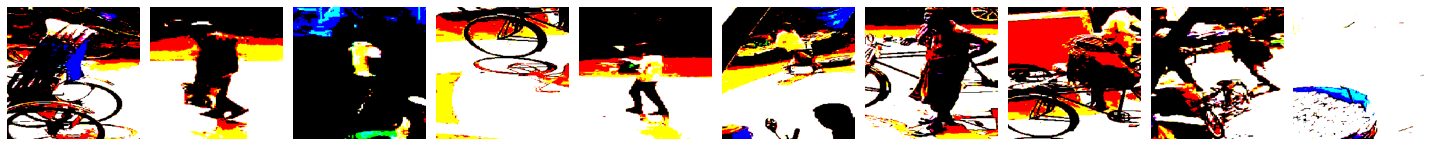

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [3]:
# Creating Data batches after vgg16 image pre-processing
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), classes=['human', 'null'], batch_size=10)
validate_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224), classes=['human', 'null'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224), classes=['human', 'null'], batch_size=10, shuffle=False)

# Function for plotting img
def plotImages(img_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(img_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
imgs, labels = next(train_batches)
plotImages(imgs)
print(labels)

In [4]:
# Tuning the model. 
# Tuning with VGG16
# Building a Finely tuned VGG16 model - Needs Internet connection

vgg16_model = tf.keras.applications.vgg16.VGG16()

vgg16_model.summary()


model_path = os.path.join(CURR_PATH, 'data', 'phase2', 'vgg16')
# os.makedirs(model_path)
# model.save(model_path)
print("Model path created at "+model_path)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
type(vgg16_model)

tensorflow.python.keras.engine.functional.Functional

In [5]:
# Find Params in VGG16
def count_params(model):
    non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_weights])
    trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
    return {'non_trainable_params': non_trainable_params, 'trainable_params': trainable_params}

params = count_params(vgg16_model)
assert params['non_trainable_params'] == 0
assert params['trainable_params'] == 138357544


In [7]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [11]:
type(model)

tensorflow.python.keras.engine.sequential.Sequential

In [9]:
params = count_params(model)
assert params['non_trainable_params'] == 0
assert params['trainable_params'] == 134260544

for layer in model.layers:
    layer.trainable = False

In [12]:
model.add(Dense(units=2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [13]:

params = count_params(model)
assert params['non_trainable_params'] == 134260544
assert params['trainable_params'] == 8194

In [17]:
# Training VGG 16 model

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x=train_batches, validation_data=validate_batches, epochs=5, verbose=2)

Epoch 1/5


KeyboardInterrupt: 